In [1]:
import telnetlib
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
%matplotlib inline

0.1620639999999991
4000


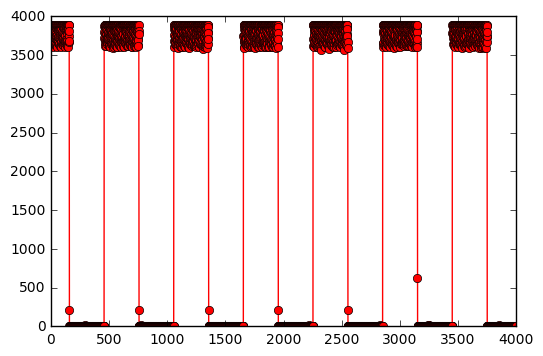

In [18]:
import time
ip = "192.168.0.121"
tel = telnetlib.Telnet(ip)
t = time.clock()
s = tel.read_until(b"END").decode().replace("END","")
tel.close()
data = pd.read_csv(io.StringIO(s),sep=";",names=["t","V"],
                   dtype={"t": np.float64, "V": np.float64})
data = data.values
print(time.clock() - t)
print(len(data))
plt.plot(data[:,0],data[:,1],"ro-")

#np.savetxt("pol_fibra_azul_baja_p.csv", data, delimiter=',')

In [ ]:
def get_freq(T,V):
    fft = np.fft.rfft(V)
    freq = np.fft.rfftfreq(len(T), d = np.diff(T)[0])
    
    #Elimino el máximo inicial, que es un artefácto del algoritmo
    freq = freq[1:]
    fft = np.abs(fft[1:])
    
    #Obtengo el valor máximo, que va a ser la fundamental de la señal
    max_fft = fft == fft.max()
    
    #Ploteo de debuggeo
    
    #plt.plot(freq[freq < 200], fft[freq < 200],"bo-")
    #plt.plot(freq[max_fft], fft[max_fft],"ro")
    
    #Devuelvo la frecuencia, como float
    return freq[max_fft][0]

#data = A[:500,:].copy()
#data[:,0] = data[:,0] - data[:,0].min()
nmin = 0
nmax = len(data)
T = (data[nmin:nmax,0] - data[nmin:nmax,0].min()) * 1e-6
V = data[nmin:nmax,1]

#Obtengo automáticamente la frecuencia, a partir de FFT
f = get_freq(T,V)

filt = sp.signal.medfilt(V,kernel_size=25)
gauss = np.abs(sp.ndimage.gaussian_filter(filt, 10, order=1))
gauss = gauss/gauss.max()

fig = plt.figure(1)
plt.plot(T, V,'ro-')
#Plot de debuggeo
#plt.plot(T,gauss*V.max(),'bo')

peaks = sp.signal.find_peaks_cwt(gauss, np.array([50]))
plt.plot(T[peaks],V[peaks],'bd')

err_f = lambda x, a, b, c, d: a + b * sp.special.erf(np.sqrt(2)*(x - c) / d)

w = 2 * np.pi * 50
R = 10
σ = []
DeltaT = 0.2/f
for i in peaks:
    try:
        ind = np.abs(T - T[i]) < DeltaT
        x = T[ind]
        y = V[ind]
        p0 = [y.max()/2, -y.max()/2, (x.max() + x.min())/2, 0.5*(x.max() - x.min())]

        p, cov = sp.optimize.curve_fit(err_f, x, y, p0 = p0)
        t = np.linspace(x.min(), x.max() , 1000)
        plt.plot(t, err_f(t,*p),figure=fig, linewidth=2)
        #print(p[3]*R*w)
        σ.append(p[3]*R*w)
    except ValueError:
        pass
    except RuntimeError:
        print("No se pudo ajustar")
        pass

        #A.append(mod_max(int(i + DeltaT/2)))
print(σ)
print("σ = {:.2f} +- {:.2f}".format(np.mean(np.array(σ)), np.sqrt(np.var(np.array(σ)))))
#print(np.sqrt(np.var(np.array(σ)))/np.mean(np.array(σ)))

In [ ]:
np.savetxt("plastico_15_5.csv", data)